## Load Libraries and Dataset

In [1]:
# import required libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sqlite3
import string

In [2]:
# Import dataset

df = pd.read_csv('train_preprocess.tsv.txt',sep='\t',names=['Tweet','Label'])
df.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
# Row and column check

df.shape

(11000, 2)

In [4]:
# General info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11000 non-null  object
 1   Label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


- Dataset consist 11000 row and 2 columns (`Tweet` and `Label`)
- All data type is object (string)

## Missing and Duplicated Value Check

In [5]:
# Missing value check

df.isna().sum()

Tweet    0
Label    0
dtype: int64

In [6]:
# Duplicated data check

print('There are {} duplicated data'.format(df.duplicated().sum()))

There are 67 duplicated data


In [7]:
# Drop duplicated data

df = df.drop_duplicates()
print('There are {} duplicated data'.format(df.duplicated().sum()))
print('Duplicated data already dropped')

There are 0 duplicated data
Duplicated data already dropped


In [8]:
# Row and column check

df.shape

(10933, 2)

- There are no missing values in dataset
- There are 67 duplicated data in dataset and already dropped (consist 10933 row)

# EDA

We will check label and word total distribution.

In [9]:
# Label distribution

df.Label.value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

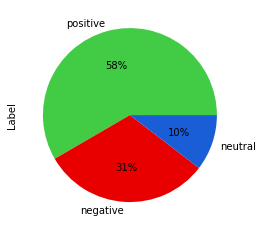

In [10]:
# Visualize it

df.Label.value_counts().plot.pie(autopct='%1.0f%%', colors = ['#42cb45','#e80000','#195dd7'])
plt.show()

In [11]:
# Create total word column

df['total_word'] = df['Tweet'].apply(lambda word: len(word.split()))

# Check new dataset

df.head()

,Tweet,Label,total_word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38


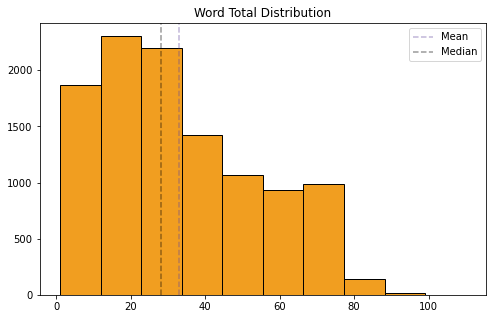

In [12]:
# Data distribution visualization

fig = plt.figure(figsize=(8,5))
plt.hist(df['total_word'], color='#f19e20', edgecolor = 'Black')
plt.axvline(x=df['total_word'].mean(),ls='--',color='#62479e',alpha=0.4,label='Mean')
plt.axvline(x=df['total_word'].median(),ls='--',color='black',alpha=0.4,label='Median')
plt.title('Word Total Distribution', size=12)
plt.legend()
plt.show()

In [13]:
# Mean and median value from total of word

print('Mean: {}'.format(df['total_word'].mean()))
print('\t')
print('Median: {}'.format(df['total_word'].median()))

Mean: 33.060550626543495
	
Median: 28.0


- The dataset consists 6383 (58%) positive labels, 3412 (31%) negative labels, and 1138 (10%) neutral labels
- Total word distribution is positive skew with majority in 20-30 words
- Mean and median from total word are 33 and 28 words

## Text Processing

Next, we will do text preprocessing so that the text data becomes even more structured. For this, we will use RegEx library.

In [14]:
# Drop total_word column

df = df.drop('total_word', axis=1)

In [15]:
# Convert to lowercase

def lowercase(s):
    return s.lower()

In [16]:
# Remove punctuation

def punctuation(s):
    s = re.sub('[^0-9a-zA-Z]+', ' ', s)
    s = re.sub('^rt',' ', s)
    s = re.sub(r'\d+', '', s)
    s = re.sub('user',' ', s)
    s = re.sub(r':', ' ', s)
    s = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', s)
    s = re.sub(' +', ' ', s)
    s = re.sub('\n',' ',s)
    s = re.sub(r'pic.twitter.com.[\w]+', ' ', s)
    return s

Besides using the regex library, we will replace non-standard words with more standard words with the help of 'kamusalay' dictionary and RDBMS (SQlite).

In [17]:
# Create database connection

conn = sqlite3.connect('database.db')

In [18]:
# Import kamusalay

kamusalay = pd.read_csv('new_kamusalay.csv',encoding='latin-1',names=['alay','normal'])

# Connect kamusalay to database

kamusalay.to_sql('kamusalay', conn, if_exists='replace',index=False)
kamusalay=pd.DataFrame(kamusalay)
kamusalay

,alay,normal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [19]:
# Retrieve kamusalay

db = sqlite3.connect('C:/Users/ASUS/Documents/Platinum Challenge/database.db', check_same_thread = False)
q_kamusalay = 'SELECT * FROM kamusalay'
t_kamusalay = pd.read_sql_query(q_kamusalay, db)

In [20]:
# Change non standard words to become more standard words

alay_dict = dict(zip(t_kamusalay['alay'], t_kamusalay['normal']))
def alay_to_normal(s):
    for word in alay_dict:
        return ' '.join([alay_dict[word] if word in alay_dict else word for word in s.split(' ')])

In [21]:
# Copy dataset

data = df.copy()
data.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [22]:
# Create text cleansing function

def cleansing(s):
    s = lowercase(s)
    s = punctuation(s)
    s = alay_to_normal(s)
    return s

In [23]:
# Apply cleansing function to dataset

data['Tweet'] = data['Tweet'].apply(cleansing)
data.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [24]:
# Old tweet and new tweet comparation

print('Old tweet: {}'.format(df['Tweet'].iloc[28]))
print('\t')
print('New tweet: {}'.format(data['Tweet'].iloc[28]))

Old tweet: pdip sebut ridwan kamil menang karena berbaju merah
	
New tweet: partai demokrasi indonesia perjuangan sebut ridwan kamil menang karena berbaju merah


## Data Storing

The cleaned dataset will be stored in the database (SQlite).

In [25]:
# Connect cleaned data to database

data.to_sql('data', conn, if_exists='replace',index=False)
data=pd.DataFrame(data)
data

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
...,...,...
10993,f demokrat dorong upaya kemandirian energi nas...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,pagi pagi di tol pasteur sudah macet parah bik...,negative


In [26]:
# Close the database

conn.commit()
conn.close()